<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/numpyro_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[NumPyro](https://github.com/pyro-ppl/numpyro) is probabilistic programming language built on top of JAX. It is very similar to [Pyro](https://pyro.ai/), which is built on top of PyTorch.
However, the HMC algorithm in NumPyro 
 [is much faster](https://stackoverflow.com/questions/61846620/numpyro-vs-pyro-why-is-former-100x-faster-and-when-should-i-use-the-latter). 

Both Pyro flavors are usually also [faster than PyMc3](https://www.kaggle.com/s903124/numpyro-speed-benchmark), and allow for more complex models, since Pyro is integrated into Python.




# Installation

In [11]:

import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import math

In [2]:
# https://github.com/pyro-ppl/numpyro/issues/531#issuecomment-826005972
# https://forum.pyro.ai/t/gpu-on-colab/2155/5
#!pip install numpyro
#!pip install --upgrade jaxlib==0.1.62+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html


!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro


In [15]:

import jax
print("jax version {}".format(jax.__version__))
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))

import jax.numpy as jnp
from jax import random

jax version 0.2.12
jax backend gpu


In [16]:
import numpyro
#numpyro.set_platform('gpu')
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.diagnostics import hpdi, print_summary

from numpyro.infer.autoguide import AutoLaplaceApproximation

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)



# Example: 1d Gaussian with unknown mean.

We use the simple example from the [Pyro intro](https://pyro.ai/examples/intro_part_ii.html#A-Simple-Example). The goal is to infer the weight $\theta$ of an object, given noisy measurements $y$. We assume the following model:
$$
\begin{align}
\theta &\sim N(\mu=8.5, \tau^2=1.0)\\ 
y \sim &N(\theta, \sigma^2=0.75^2)
\end{align}
$$

Where $\mu=8.5$ is the initial guess. 


## Exact inference


By Bayes rule for Gaussians, we know that the exact posterior,
given a single observation $y=9.5$, is given by


$$
\begin{align}
\theta|y &\sim N(m, s^s) \\
m &=\frac{\sigma^2 \mu + \tau^2 y}{\sigma^2 + \tau^2} 
  = \frac{0.75^2 \times 8.5 + 1 \times 9.5}{0.75^2 + 1^2}
  = 9.14 \\
s^2 &= \frac{\sigma^2 \tau^2}{\sigma^2  + \tau^2} 
= \frac{0.75^2 \times 1^2}{0.75^2 + 1^2}= 0.6^2
\end{align}
$$

In [17]:
mu = 8.5; tau = 1.0; sigma = 0.75;
hparams = (mu, tau, sigma)

y = 9.5
m = (sigma**2 * mu + tau**2 * y)/(sigma**2 + tau**2)
s2 = (sigma**2 * tau**2)/(sigma**2 + tau**2)
s = np.sqrt(s2)
print(m)
print(s)

9.14
0.6


In [18]:

def model(hparams, y=None):
    prior_mean, prior_sd, obs_sd = hparams
    theta = numpyro.sample("theta", dist.Normal(prior_mean, prior_sd))
    y = numpyro.sample("y", dist.Normal(theta, obs_sd), obs=y)
    return y



## Ancestral sampling

In [7]:
def model2(hparams):
    prior_mean, prior_sd, obs_sd = hparams
    theta = numpyro.sample("theta", dist.Normal(prior_mean, prior_sd))
    yy = numpyro.sample("y", dist.Normal(theta, obs_sd))
    return theta, yy

In [8]:
with numpyro.handlers.seed(rng_seed=0):
  for i in range(5):
    theta, yy = model2(hparams)
    print([theta, yy])

[DeviceArray(7.248, dtype=float32), DeviceArray(6.808, dtype=float32)]
[DeviceArray(8.986, dtype=float32), DeviceArray(9.149, dtype=float32)]
[DeviceArray(7.851, dtype=float32), DeviceArray(8.856, dtype=float32)]
[DeviceArray(9.538, dtype=float32), DeviceArray(8.973, dtype=float32)]
[DeviceArray(7.895, dtype=float32), DeviceArray(6.133, dtype=float32)]


## MCMC

See [the documentation](https://num.pyro.ai/en/stable/mcmc.html)

In [9]:
conditioned_model = numpyro.handlers.condition(model, {'y': y})
nuts_kernel = NUTS(conditioned_model)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=1000)
mcmc.run(rng_key_, hparams)

mcmc.print_summary()
samples  = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:02<00:00, 395.76it/s, 3 steps of size 1.58e+00. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      9.09      0.60      9.09      8.11     10.07    350.32      1.00

Number of divergences: 0


In [10]:
print(type(samples))
print(type(samples['theta']))
print(samples['theta'].shape)

<class 'dict'>
<class 'jax.interpreters.xla._DeviceArray'>
(1000,)


In [11]:
nuts_kernel = NUTS(model) # this is the unconditioned model
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=1000)
mcmc.run(rng_key_, hparams, y) # we need to specify the observations here

mcmc.print_summary()
samples  = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:02<00:00, 386.90it/s, 3 steps of size 1.58e+00. acc. prob=0.83]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      9.09      0.60      9.09      8.11     10.07    350.32      1.00

Number of divergences: 0


## Stochastic variational inference

See [the documentation](https://num.pyro.ai/en/stable/svi.html)

100%|██████████| 2000/2000 [00:01<00:00, 1295.73it/s, init loss: 1.8902, avg. loss [1901-2000]: 1.4572]


{'m': DeviceArray(9.084, dtype=float32), 's': DeviceArray(0.586, dtype=float32)}
(2000,)


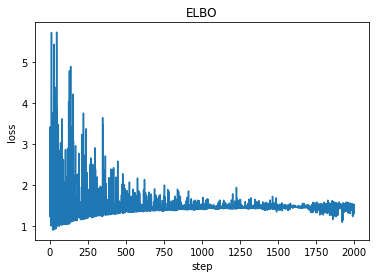

In [12]:
# the guide must have the same signature as the model
def guide(hparams, y):
  prior_mean, prior_sd, obs_sd = hparams
  m = numpyro.param("m", y) # location
  s = numpyro.param("s", prior_sd, constraint=constraints.positive) # scale
  return numpyro.sample("theta", dist.Normal(m, s))


# The optimizer wrap these, so have unusual keywords
#https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html

#optimizer = numpyro.optim.Adam(step_size=0.001)
optimizer = numpyro.optim.Momentum(step_size=0.001, mass=0.1)
#svi = SVI(model, guide, optimizer, Trace_ELBO(), hparams=hparams, y=y) # specify static args to model/guide
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
nsteps = 2000
svi_result = svi.run(rng_key_, nsteps, hparams, y) # or specify arguments here

print(svi_result.params)
print(svi_result.losses.shape)
plt.plot(svi_result.losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

In [14]:
print([svi_result.params['m'], svi_result.params['s']])

[DeviceArray(9.084, dtype=float32), DeviceArray(0.586, dtype=float32)]


## Laplace (quadratic) approximation

See [the documentation](https://num.pyro.ai/en/stable/autoguide.html#autolaplaceapproximation)

100%|██████████| 2000/2000 [00:01<00:00, 1607.21it/s, init loss: 155.0839, avg. loss [1901-2000]: 1.8711]


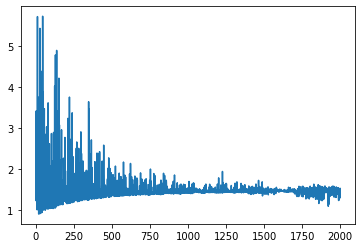

In [17]:
guide_laplace = AutoLaplaceApproximation(model)
svi = SVI(model, guide_laplace, optimizer, Trace_ELBO(), hparams=hparams, y=y)
svi_run = svi.run(rng_key_, 2000)
params = svi_run.params
losses = svi_result.losses

plt.figure()
plt.plot(losses)

In [22]:
# Posterior is an MVN
# https://num.pyro.ai/en/stable/distributions.html#multivariatenormal
post = guide_laplace.get_posterior(params)
print(post)
m = post.mean
s = jnp.sqrt(post.covariance_matrix)
print([m, s])

[DeviceArray([9.118], dtype=float32), DeviceArray([[0.6]], dtype=float32)]


In [23]:
samples = guide_laplace.sample_posterior(rng_key_, params, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     theta      9.16      0.61      9.12      8.18     10.04    955.50      1.00



# Example: Beta-Bernoulli model


Example is from [SVI tutorial](https://pyro.ai/examples/svi_part_i.html)

The model is
$$
\begin{align}
\theta &\sim \text{Beta}(\alpha, \beta) \\
x_i &\sim \text{Ber}(\theta)
\end{align}
$$
where $\alpha=\beta=10$. In the code, $\theta$ is called 
 `latent_fairness`. 

In [7]:
alpha0 = 10.0
beta0 = 10.0

def model(data):
    f = numpyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        numpyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

In [8]:
# create some data with 6 observed heads and 4 observed tails
data = jnp.hstack((jnp.ones(6), jnp.zeros(4)))
print(data)
N1 = jnp.sum(data==1)
N0 = jnp.sum(data==0)
print([N1, N0])

[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
[DeviceArray(6, dtype=int32), DeviceArray(4, dtype=int32)]


## Exact inference

The posterior is given by
$$
\begin{align}
\theta &\sim \text{Ber}(\alpha + N_1, \beta  + N_0) \\
N_1 &= \sum_{i=1}^N [x_i=1] \\
N_0 &= \sum_{i=1}^N [x_i=0]
\end{align}
$$

In [9]:
alpha_q = alpha0 + N1
beta_q = beta0 + N0
print('exact posterior: alpha={:0.3f}, beta={:0.3f}'.format(alpha_q, beta_q))

post_mean = alpha_q / (alpha_q + beta_q)
post_var = (post_mean * beta_q)/((alpha_q + beta_q) * (alpha_q + beta_q + 1))
post_std = np.sqrt(post_var)
print([post_mean, post_std])

exact posterior: alpha=16.000, beta=14.000
[DeviceArray(0.533, dtype=float32), 0.08960287]


In [12]:
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)
print([inferred_mean, inferred_std])

[DeviceArray(0.533, dtype=float32), DeviceArray(0.09, dtype=float32)]


## Variational inference

In [48]:
def guide(data):
    alpha_q = numpyro.param("alpha_q", alpha0,
                         constraint=constraints.positive)
    beta_q = numpyro.param("beta_q", beta0,
                        constraint=constraints.positive)
    numpyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

100%|██████████| 2000/2000 [00:03<00:00, 605.23it/s, init loss: 6.8058, avg. loss [1901-2000]: 7.0744]


{'alpha_q': DeviceArray(13.071, dtype=float32), 'beta_q': DeviceArray(11.132, dtype=float32)}
(2000,)


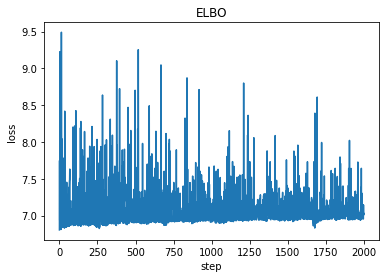

In [49]:

#optimizer = numpyro.optim.Adam(step_size=0.001)
optimizer = numpyro.optim.Momentum(step_size=0.001, mass=0.1)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
nsteps = 2000
svi_result = svi.run(rng_key_, nsteps, data) 

print(svi_result.params)
print(svi_result.losses.shape)
plt.plot(svi_result.losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

In [54]:
# grab the learned variational parameters
alpha_q = svi_result.params["alpha_q"]
beta_q = svi_result.params["beta_q"]
print('variational posterior: alpha={:0.3f}, beta={:0.3f}'.format(alpha_q, beta_q))

post_mean = alpha_q / (alpha_q + beta_q)
post_var = (post_mean * beta_q)/((alpha_q + beta_q) * (alpha_q + beta_q + 1))
post_std = np.sqrt(post_var)
print([post_mean, post_std])

variational posterior: alpha=13.071, beta=11.132
[DeviceArray(0.54, dtype=float32), 0.09927754]


## MCMC

In [52]:
nuts_kernel = NUTS(model) # this is the unconditioned model
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=1000)
mcmc.run(rng_key_, data) 

mcmc.print_summary()
samples  = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:05<00:00, 207.57it/s, 3 steps of size 1.16e+00. acc. prob=0.88]



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
  latent_fairness      0.53      0.09      0.53      0.37      0.68    380.27      1.00

Number of divergences: 0


# Distributions

## 1d Gaussian

In [ ]:
# 2 independent 1d gaussians (ie 1 diagonal Gaussian)
mu = 1.5
sigma = 2
d = dist.Normal(mu, sigma)
dir(d)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_shape',
 '_event_shape',
 '_validate_args',
 '_validate_sample',
 'arg_constraints',
 'batch_shape',
 'enumerate_support',
 'event_dim',
 'event_shape',
 'expand',
 'expand_by',
 'has_enumerate_support',
 'icdf',
 'is_discrete',
 'loc',
 'log_prob',
 'mask',
 'mean',
 'reparametrized_params',
 'sample',
 'sample_with_intermediates',
 'scale',
 'set_default_validate_args',
 'shape',
 'support',
 'to_event',
 'tree_flatten',
 'tree_unflatten',
 'variance']

In [ ]:
rng_key, rng_key_ = random.split(rng_key)
nsamples = 1000
ys = d.sample(rng_key_, (nsamples,))
print(ys.shape)
mu_hat = np.mean(ys,0)
print(mu_hat)
sigma_hat = np.std(ys, 0)
print(sigma_hat)

(1000,)
1.5070927
2.0493808


## Multivariate Gaussian



In [ ]:
mu = np.array([-1, 1])
sigma = np.array([1, 2])
Sigma = np.diag(sigma)
d2 = dist.MultivariateNormal(mu, Sigma)

In [ ]:
#rng_key, rng_key_ = random.split(rng_key)
nsamples = 1000
ys = d2.sample(rng_key_, (nsamples,))
print(ys.shape)
mu_hat = np.mean(ys,0)
print(mu_hat)
Sigma_hat = np.cov(ys, rowvar=False) #jax.np.cov not implemented
print(Sigma_hat)

(1000, 2)
[-1.0127413  1.0091063]
[[ 0.9770031  -0.00533966]
 [-0.00533966  1.9718108 ]]


## Shape semantics

Numpyro, [Pyro](https://pyro.ai/examples/tensor_shapes.html) and [TFP](https://www.tensorflow.org/probability/examples/Understanding_TensorFlow_Distributions_Shapes) all distinguish between 'event shape' and 'batch shape'.
For a D-dimensional Gaussian, the event shape is (D,), and the batch shape
will be (), meaning we have a single instance of this distribution.
If the covariance is diagonal, we can view this as D independent
1d Gaussians, stored along the batch dimension; this will have event shape () but batch shape (2,). 

When we sample from a distribution, we also specify the sample_shape.
Suppose we draw N samples  from a single D-dim diagonal Gaussian,
and N samples from D 1d Gaussians. These samples will have the same shape.
However, the semantics of logprob differs.
We illustrate this below.


In [ ]:
d2 = dist.MultivariateNormal(mu, Sigma)
print(f'event shape {d2.event_shape}, batch shape {d2.batch_shape}') 
nsamples = 3
ys2 = d2.sample(rng_key_, (nsamples,))
print('samples, shape {}'.format(ys2.shape))
print(ys2)

# 2 independent 1d gaussians (same as one 2d diagonal Gaussian)
d3 = dist.Normal(mu, np.diag(Sigma))
print(f'event shape {d3.event_shape}, batch shape {d3.batch_shape}') 
ys3 = d3.sample(rng_key_, (nsamples,))
print('samples, shape {}'.format(ys3.shape))
print(ys3)

print(np.allclose(ys2, ys3))

event shape (2,), batch shape ()
samples, shape (3, 2)
[[-0.06819373  0.9942934 ]
 [-1.740325   -1.0183868 ]
 [ 0.05969942  2.314332  ]]
event shape (), batch shape (2,)
samples, shape (3, 2)
[[-0.06819373  0.99192965]
 [-1.740325   -1.85443   ]
 [ 0.05969942  2.8587465 ]]
False


In [ ]:
y = ys2[0,:] # 2 numbers
print(d2.log_prob(y)) # log prob of a single 2d distribution on 2d input 
print(d3.log_prob(y)) # log prob of two 1d distributions on 2d input


-2.6185904
[-1.35307   -1.6120898]


We can turn a set of independent distributions into a single product
distribution using the [Independent class](http://num.pyro.ai/en/stable/distributions.html#independent)


In [ ]:
d4 = dist.Independent(d3, 1) # treat the first batch dimension as an event dimensions
print(d4.event_shape)
print(d4.batch_shape)
print(d4.log_prob(y))

(2,)
()
-2.96516
